# Titanic

## Exploratory analysis

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

### Import data
file: `train.csv` and `test.csv`
The Titanic dataset is a well-known and frequently used dataset in the field of machine learning and data analysis. It contains information about the passengers who were aboard the RMS Titanic during its ill-fated maiden voyage in 1912.

In [25]:
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")
print(train_df.shape)
print(test_df.shape)

(891, 12)
(418, 11)


In [26]:
cols = train_df.columns
cols

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [27]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


**Count** is the number of entries in a particular column, we can see that Age is incomplete. 

**Mean** is the average of each column. E.g. The average fare us 32.2 USD

**Std** is standard deviation of all data. A low standard deviation means that most of the numbers are close to the average, while a high standard deviation means that the numbers are more spread out. Again ‘Fare’ has a high standard deviation.

**Min** is the minimum value of each column. For example, the lowest ‘Fare’ shows 0 USD, which means ‘Fare’ is unavailable for some passengers. The model may not perform well with 0 for some passengers. Hence we will need to focus on the ‘Fare’ column before modeling.

**Max** is the maximum value of the column. For example, the highest ‘Fare’ shows 512.33 USD. The mean of the ‘Fare’ column says USD 32.20. We see there is a huge difference in fare. It could be because of the ‘Pclass’ they were traveling.

**25%, 50% & 75%** are the 1st, 2nd, and 3rd quartile of the data. Quartile in statistics is a type of quantile that divides the number of ordered data points into four equal groups. 1st quartile is the middle number between the smallest number and the median. 2nd quartile is the median of the dataset. 3rd quartile is the middle value between the median and the highest value.


In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [29]:
train_df.isnull().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [30]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

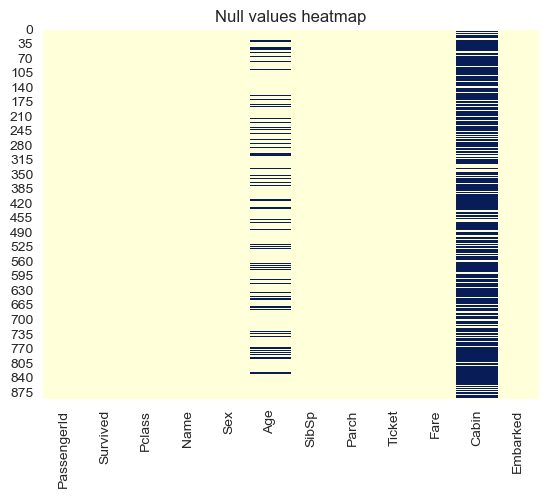

In [31]:
ax = plt.axes()
sns.heatmap(train_df.isnull(), cmap='YlGnBu', cbar=False, ax=ax)
ax.set_title('Null values heatmap')
plt.show()

### Data cleaning

Since cabin has a lot of NaN values, we will create a new feature called has cabin which will have 1 for Cabin a 0 for NaN values.

In [32]:
def clean_cabins(df):
    return np.where(df["Cabin"].isnull(), 0, 1)

train_df["has_cabin"] = clean_cabins(train_df)
test_df["has_cabin"] = clean_cabins(test_df)


Now for the embarked missing values, we will assign S (Southampton)

In [33]:
def clean_embarked(df):
    return df["Embarked"].fillna("S")


train_df["Embarked"] = clean_embarked(train_df)
test_df["Embarked"] = clean_embarked(test_df)


Age feature has a lot of missing values. We will fill them with random values centered around the mean and distributed with standard deviation.

In [34]:
def clean_age(df):
    mean = df["Age"].mean()
    std = df["Age"].std()
    min = mean - std
    max = mean + std
    return df["Age"].fillna(np.random.randint(min, max))

train_df["Age"] = clean_age(train_df)
test_df["Age"] = clean_age(test_df)


In [35]:
def clean_fare(df):
    mean = df["Fare"].mean()
    std = df["Fare"].std()
    min = mean - std
    max = mean + std
    return df["Fare"].fillna(np.random.randint(min, max))


train_df["Fare"] = clean_fare(train_df)
test_df["Fare"] = clean_fare(test_df)

test_df.isnull().sum()


PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
has_cabin        0
dtype: int64

### Feature engineering
Here we will create new features that could help our model performance.

We will create a new feature called family_size by combining ‘SibSp’(Sibling & Spouse) and ‘Parch’(Parent & Children).

In [36]:
def create_fam_size(df):
    return df["SibSp"] + df["Parch"] + 1


train_df["family_size"] = create_fam_size(train_df)
test_df["family_size"] = create_fam_size(test_df)


The fare column contains 0's for some passengers and pretty high values for others. We will split the fare into four categories and create a new feature called categorical_fare

In [37]:
def create_categorical_fare(df):
    return pd.qcut(x=df["Fare"], q=4, labels=[0, 1, 2, 3]).astype(int)


train_df["categorical_fare"] = create_categorical_fare(train_df)
test_df["categorical_fare"] = create_categorical_fare(test_df)


In the name column we have many titles, we will extract them and categorize them into four categories [Mr, Miss, Mrs, Rare] and create a new feature called "title"

In [38]:
def create_categorical_title(df):
    def find_title(name: str) -> str:
        search = re.search(
            " ([A-Za-z]+)\.", name
        )  # Search for a word with a point at the end
        if search:
            title = search.group(1)
            if title in ["Mlle", "Ms"]:
                return "Miss"
            elif title in ["Mme", "Mrs"]:
                return "Mrs"
            elif title == "Mr":
                return "Mr"
            else:
                return "Rare"
        return ""

    return_title = df["Name"].apply(find_title)
    dict_title = {"Miss": 1, "Mrs": 2, "Mr": 3, "Rare": 4}
    return return_title.replace(dict_title)


train_df["Title"] = create_categorical_title(train_df)
test_df["Title"] = create_categorical_title(test_df)


Change the "Sex" and "Embarked" feature to categorical ones. (0, 1)

In [39]:
def create_categorical_sex(df):
    return np.where(df["Sex"] == "male", 1, 0)


def create_categorical_embarked(df):
    return df["Embarked"].replace({"S": 0, "C": 1, "Q": 2})


train_df["categorical_sex"] = create_categorical_sex(train_df)
train_df["Embarked"] = create_categorical_embarked(train_df)

test_df["categorical_sex"] = create_categorical_sex(test_df)
test_df["Embarked"] = create_categorical_embarked(test_df)


After data cleaning and feature engineering we check for NaN values

In [40]:
train_df.isnull().sum()


PassengerId           0
Survived              0
Pclass                0
Name                  0
Sex                   0
Age                   0
SibSp                 0
Parch                 0
Ticket                0
Fare                  0
Cabin               687
Embarked              0
has_cabin             0
family_size           0
categorical_fare      0
Title                 0
categorical_sex       0
dtype: int64

Let's drop the useless columns.

In [41]:
def remove_useless_features(df):
    drop_list = ["PassengerId", "Cabin", "Ticket", "SibSp", "Name", "Sex"]
    return df.drop(drop_list, axis=1)

train_df = remove_useless_features(train_df)
test_df = remove_useless_features(test_df)
train_df.head()


,Survived,Pclass,Age,Parch,Fare,Embarked,has_cabin,family_size,categorical_fare,Title,categorical_sex
0,0,3,22.0,0,7.2500,0,0,2,0,3,1
1,1,1,38.0,0,71.2833,1,1,2,3,2,0
2,1,3,26.0,0,7.9250,0,0,1,1,4,0
3,1,1,35.0,0,53.1000,0,1,2,3,2,0
4,0,3,35.0,0,8.0500,0,0,1,1,3,1


### Correlation

<Axes: >

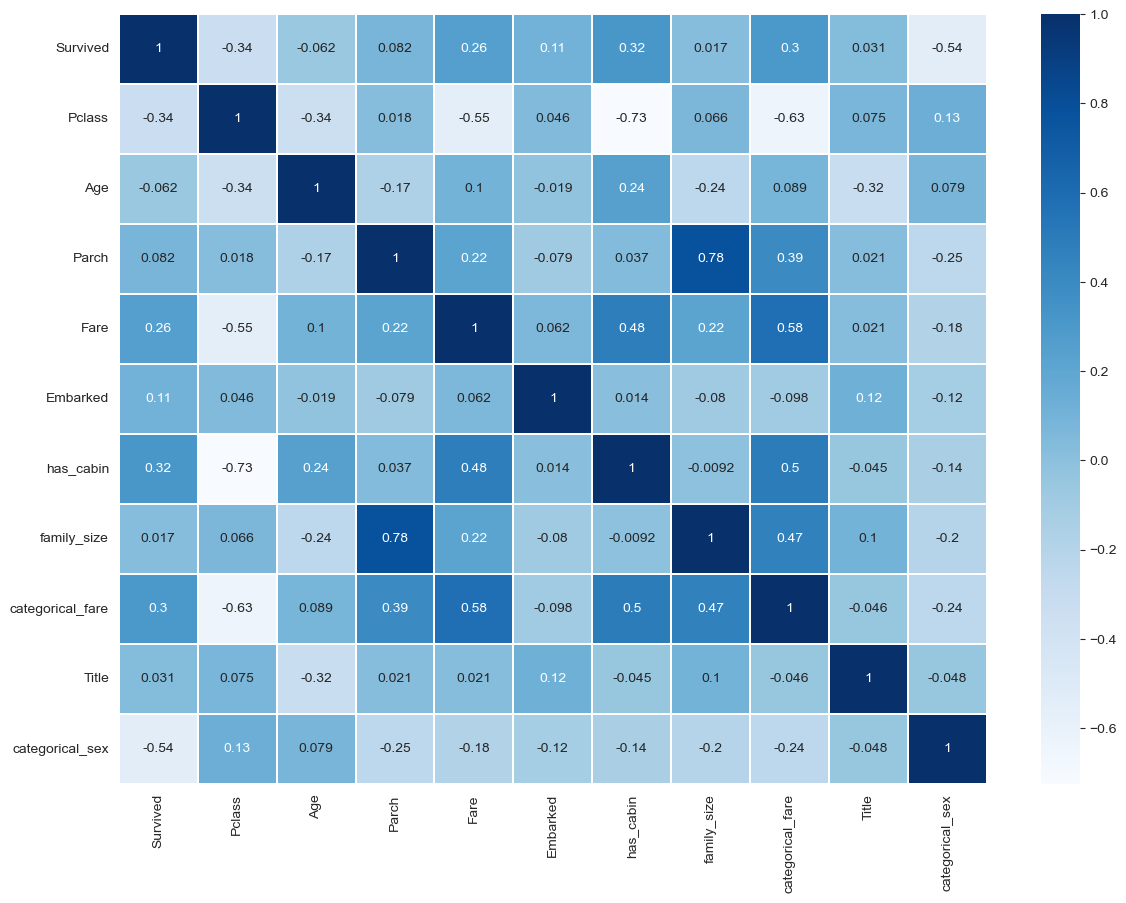

In [42]:
colormap = plt.cm.Blues
plt.figure(figsize=(14,10))
sns.heatmap(train_df.corr(), cmap=colormap, annot=True, linewidths=0.2)

Positive and Negative values denote Positive and Negative correlation. The first row of the data shows the correlation of each variable with the Target variable ‘Survived’.
For building a good predictive model, we are interested in variables that influence the target variable “Survived”. Positively or negatively. We need to consider the values that are both too high and too low.`

The first row contains the values that represent the correlation of each variable with the target variable. ‘HasCabin’ and ‘CategoricalFare’ are highly (positively) correlated with the target variable and ‘Sex Numerical’ is inversely correlated with the target variable.

### Target Variable Analysis
The Study of the target variable is a significant step in Data Analysis that reveals the nature and distribution of the variable. Let’s analyze our target variable “Survived”.

In [76]:
train_df['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

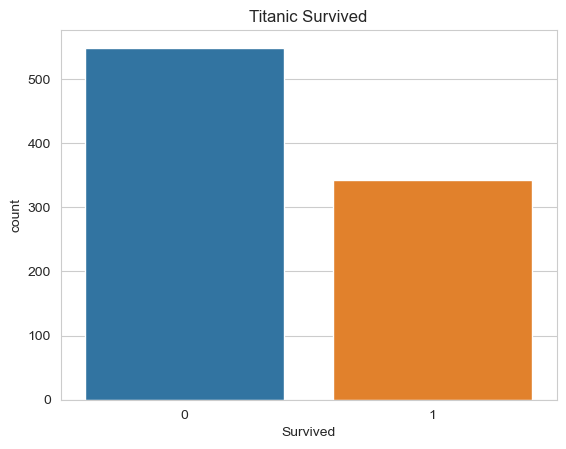

In [77]:
sns.countplot(x='Survived', data=train_df)
plt.title("Titanic Survived")
plt.show()

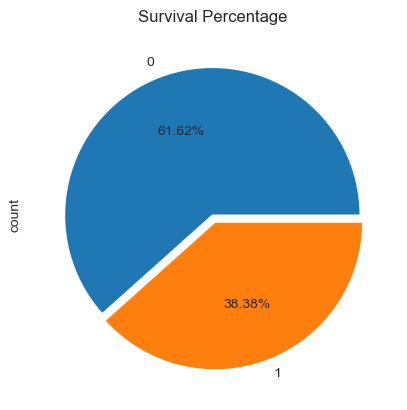

In [79]:
explode = [0, 0.05]
train_df['Survived'].value_counts().plot.pie(autopct='%1.2f%%', explode=explode)
plt.title('Survival Percentage')
plt.show()

From the above chart, 38% of the passengers are only survived based on this training data. Clearly, there is an imbalance between the classes.
### Bivariate analysis
Let's analyze the ‘Pclass’ column since it is highly correlated with the target variable.

In [80]:
train_df['Pclass'].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [83]:
train_df.groupby(['Pclass', 'Survived'])['Survived'].count()

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
Name: Survived, dtype: int64

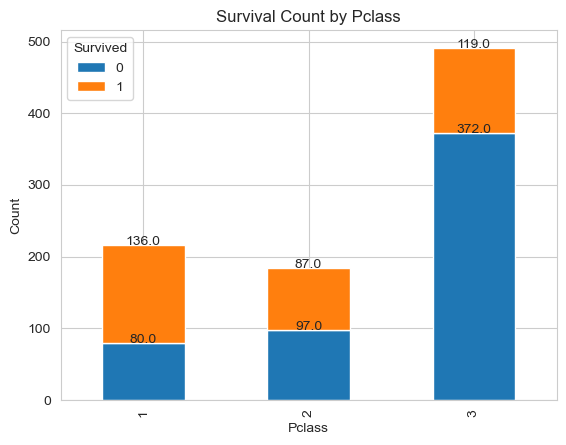

In [98]:
correlation_table = train_df.groupby(['Pclass', 'Survived'])['Survived'].count().unstack()

ax = correlation_table.plot(kind='bar', stacked=True)

plt.xlabel('Pclass')
plt.ylabel('Count')
plt.title('Survival Count by Pclass')

# Add count values on the bars
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    x, y = p.get_xy()
    ax.annotate(str(height), (x + width / 2, y + height), ha='center', va='baseline')

plt.show()

C:\Users\huunh\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


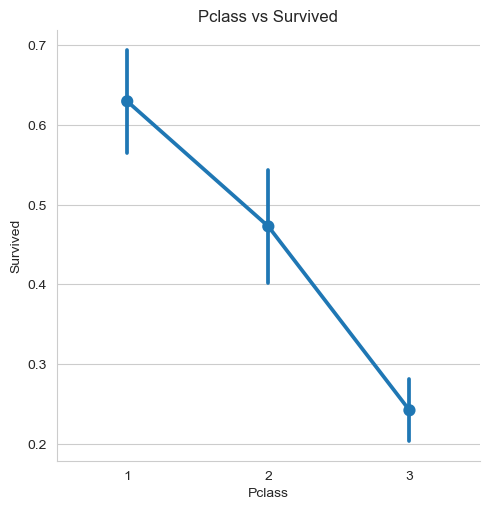

In [100]:
sns.catplot(x='Pclass', y='Survived', data=train_df, kind='point')
plt.title("Pclass vs Survived")
plt.show()

a Point plot.
It shows point estimates and confidence intervals. The point estimates indicate the central tendency of a variable while the confidence intervals indicate the uncertainty around this estimate. 
 Inconclusion: the first Class passengers had the highest Survival rate when compared to the other class passengers.

C:\Users\huunh\anaconda3\Lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\huunh\anaconda3\Lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\huunh\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


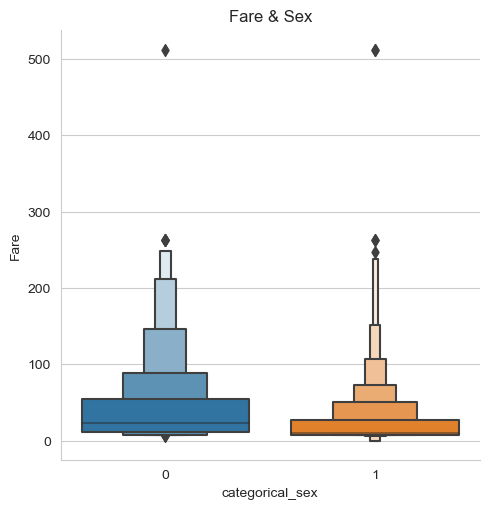

In [101]:
sns.catplot(x='categorical_sex', y='Fare', data=train_df, kind='boxen')
plt.title("Fare & Sex")
plt.show()


The enhanced box plot shown above indicates that the fare of “Female” passengers is on average higher than male passengers. It could be because of the additional services offered to female passengers.

Multivariate analysis provides a deeper understanding of the relationship between variables compared to bivariate analysis. The latter assumes that the relationship between a variable X and the target variable Y is independent of other variables, meaning that f(X, Y) does not depend on a third variable Z. This assumption can be limiting and potentially dangerous. For example, the "Women and children first" principle, followed since 1852, prioritizes saving the lives of women and children in life-threatening situations. While we already know that "Survival" is highly correlated with "Sex," the relationship between "Survival" and "Sex" is influenced by a third variable, "Age" (specifically, whether an individual is a child).

Let's compare "Sex" and "Age."

C:\Users\huunh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\huunh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\huunh\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


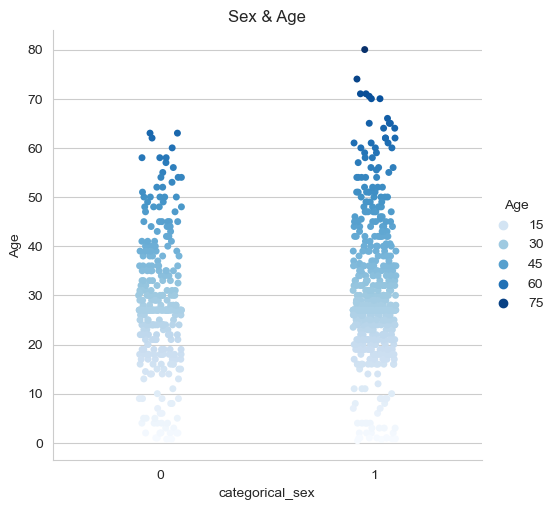

In [103]:
sns.catplot(x='categorical_sex', y='Age', data=train_df, hue="Age", palette="Blues")
plt.title("Sex & Age")
plt.show()

Let's include the third parameter “Pclass” and try to understand it better.

C:\Users\huunh\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


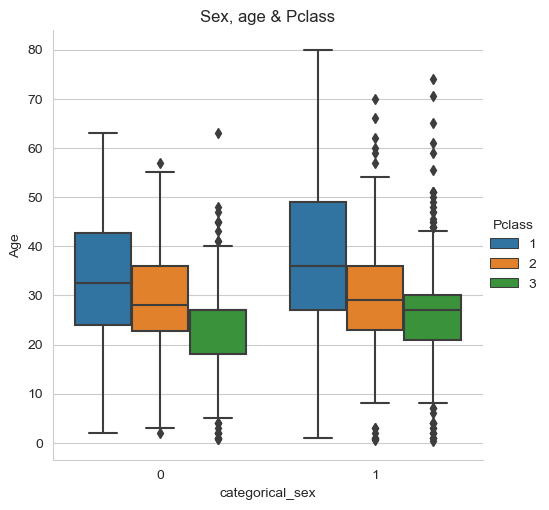

In [104]:
sns.catplot(x='categorical_sex', y='Age', data=train_df, kind='box', hue='Pclass')
plt.title("Sex, age & Pclass")
plt.show()


From the above plot, we infer that most of the older people were traveling in first class. It may be because they were rich. The youngsters who are aged between 25 and 35 were mostly traveling in second and third classes.

C:\Users\huunh\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


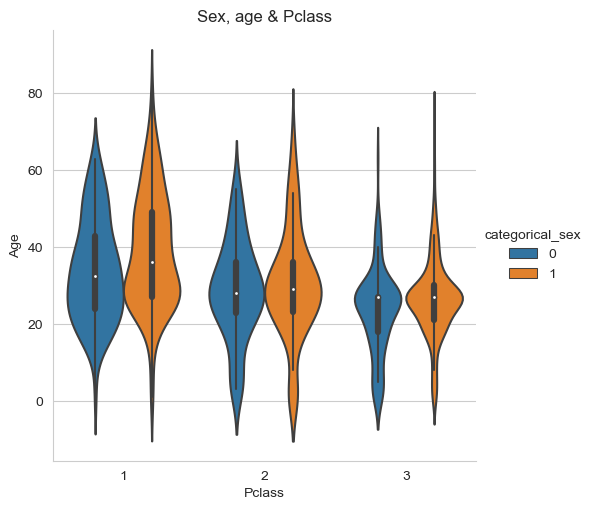

In [105]:
sns.catplot(x='Pclass', y='Age', data=train_df, kind='violin', hue='categorical_sex')
plt.title("Sex, age & Pclass")
plt.show()


C:\Users\huunh\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


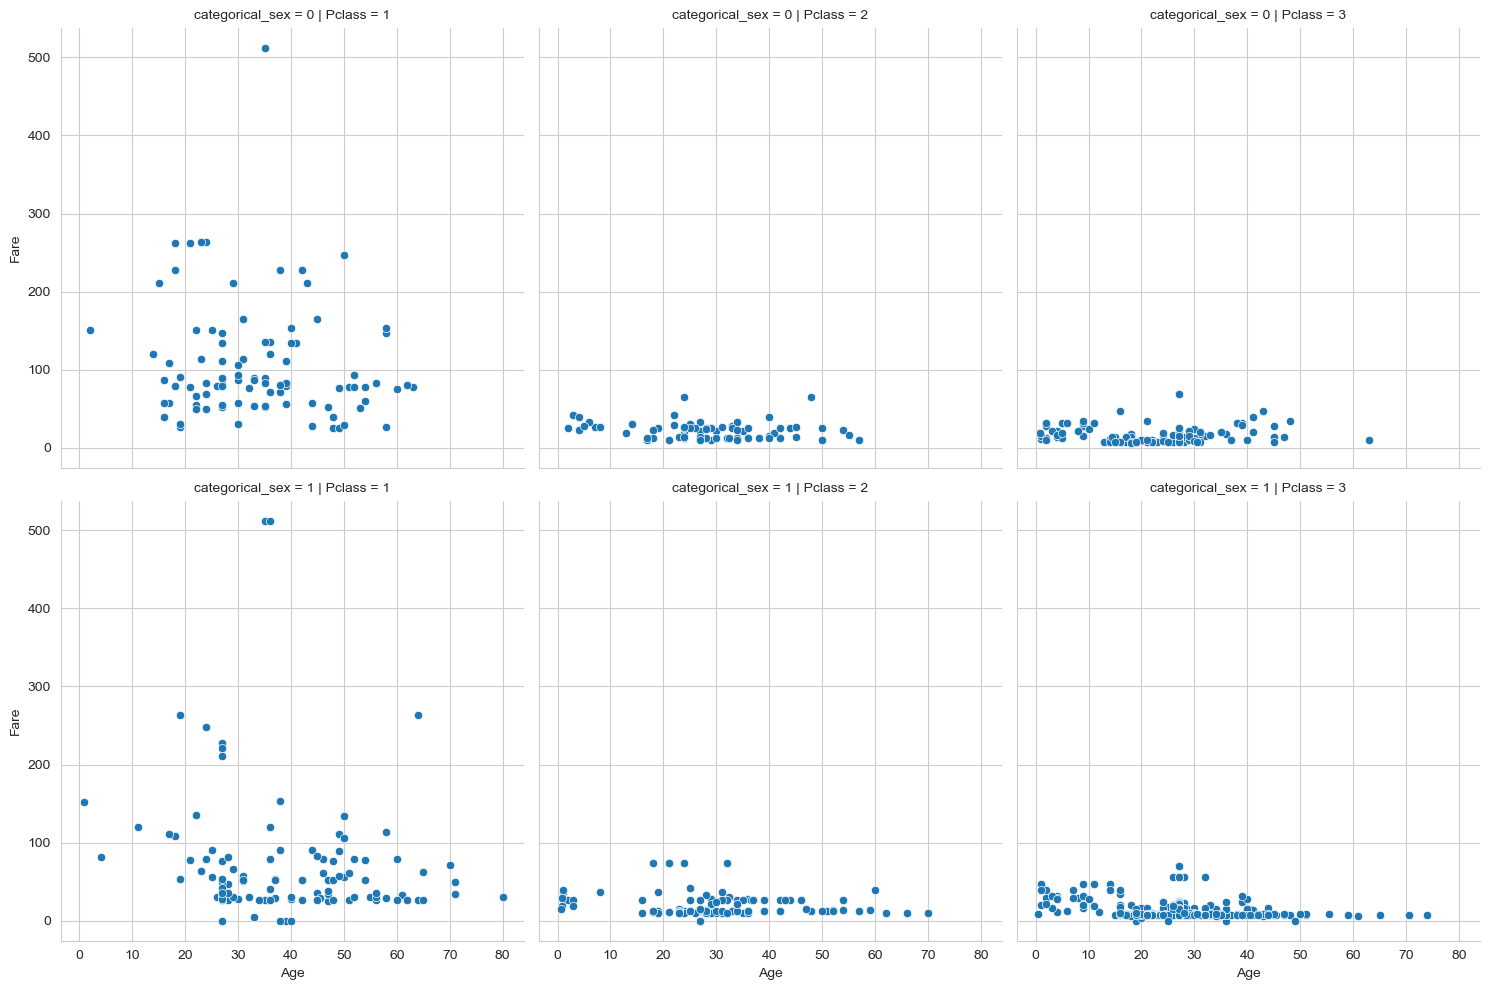

In [106]:
sns.relplot(x='Age', y='Fare', data=train_df, row='categorical_sex', col='Pclass')
plt.show()


In [107]:
train_df.head()

,Survived,Pclass,Age,Fare,Embarked,has_cabin,family_size,categorical_fare,Title,categorical_sex
758,0,3,34.0,8.1,0,0,1,1,3,1
280,0,3,65.0,7.8,2,0,1,0,3,1
401,0,3,26.0,8.1,0,0,1,1,3,1
302,0,3,19.0,0.0,0,0,1,0,3,1
781,1,1,17.0,57.0,0,1,2,3,2,0


From the above plots, we observe that there were more male passengers who traveled in first-class than women passengers. The Fare for first-class female passengers was higher than male passengers. There is no big difference in Fare for second and third-class passengers. Very few children traveled in first class. The third class had more children. Most of the second and third-class passengers were aged between 20 and 40.

## Modeling, evaluation & ensambling

In [116]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.naive_bayes import GaussianNB

# K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [108]:
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format


In [109]:
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the training set


In [110]:
x_train = train_df.drop("Survived", axis=1)
y_train = train_df["Survived"]


### Machine learning models

#### Random forest

In [118]:
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest Classifier
randomforest = RandomForestRegressor(n_estimators=100)

# Fit the model to the training data
randomforest.fit(x_train, y_train)

# Make predictions on the test data
y_pred = randomforest.predict(test_df)

# Calculate the accuracy of the model
accuracy = randomforest.score(x_train, y_train)
acc_random_forest = round(accuracy * 100, 2)

#### Logistic Regression

In [117]:
# Create a Logistic Regression model
logreg = LogisticRegression(max_iter=10000)

# Fit the model to the training data
logreg.fit(x_train, y_train)

# Make predictions on the test data
y_pred = logreg.predict(test_df)

# Calculate the accuracy of the model
accuracy = logreg.score(x_train, y_train)
acc_log = round(accuracy * 100, 2)

#### K Nearest Neighbor:

In [145]:
# Create a K-Nearest Neighbors model
knn = KNeighborsRegressor(n_neighbors=3)

# Fit the model to the training data
knn.fit(x_train, y_train)

# Make predictions on the test data
y_pred = knn.predict(test_df)

# Calculate the accuracy of the model
accuracy = knn.score(x_train, y_train)
acc_knn = round(accuracy * 100, 2)
acc_knn

55.18

#### Decision Tree

In [129]:
# Create a Decision Tree model
decision_tree = DecisionTreeRegressor()

# Fit the model to the training data
decision_tree.fit(x_train, y_train)

# Make predictions on the test data
y_pred = decision_tree.predict(test_df)

# Calculate the accuracy of the model
accuracy = decision_tree.score(x_train, y_train)
acc_decision_tree = round(accuracy * 100, 2)

96.24


#### Gaussian Naive Bayes:

In [128]:
gaussian = GaussianNB() 
gaussian.fit(x_train, y_train)  
y_pred = gaussian.predict(test_df)  
acc_gaussian = round(gaussian.score(x_train, y_train) * 100, 2)

79.24


#### Perceptron

In [127]:
perceptron = Perceptron(max_iter=10000)
perceptron.fit(x_train, y_train)

Y_pred = perceptron.predict(test_df)

acc_perceptron = round(perceptron.score(x_train, y_train) * 100, 2)
print(acc_perceptron)


75.53


#### Regression Support Vector Machine: 

In [136]:
# Create a Support Vector Regression model

from sklearn import svm

# Tạo mô hình SVR
reg = svm.SVR()

# Huấn luyện mô hình với dữ liệu
reg.fit(x_train, y_train)

# Dự đoán kết quả
y_pred = reg.predict(x_train)
acc_svr = round(reg.score(x_train, y_train) *100, 2)


C:\Users\huunh\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\huunh\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### Which is the best model?

In [138]:
results = pd.DataFrame(
    {
        "Model": [
            "KNN",
            "Logistic Regression",
            "Random Forest",
            "Naive Bayes",
            "Perceptron",
            "Decision Tree",
            "SVR"
        ],
        "Score": [
            acc_knn,
            acc_log,
            acc_random_forest,
            acc_gaussian,
            acc_perceptron,
            acc_decision_tree,
            acc_svr
        ],
    }
)
result_df = results.sort_values(by="Score", ascending=False)
result_df = result_df.set_index("Score")
result_df.head(9)


,Model
Score,
96.2,Decision Tree
89.3,Random Forest
80.6,Logistic Regression
79.2,Naive Bayes
75.5,Perceptron
55.2,KNN
8.7,SVR


Random Forest classifier is the best model. But first, we have to see, how random-forest performs, when we use cross validation.

### K-fold cross validation

K-Fold Cross Validation randomly splits the training data into K subsets called folds. Let’s image we would split our data into 4 folds (K = 4). Our random forest model would be trained and evaluated 4 times, using a different fold for evaluation everytime, while it would be trained on the remaining 3 folds.

In [69]:
scores = cross_val_score(decision_tree, x_train, y_train, cv=10, scoring="accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())


Scores: [0.8        0.79775281 0.82022472 0.74157303 0.71910112 0.76404494
 0.79775281 0.71910112 0.74157303 0.70786517]
Mean: 0.7608988764044944
Standard Deviation: 0.038507701507221534


This means our model has an average accuracy of 79% with a standard deviation of 4%. The standard deviation shows us, how precise the estimates are. This means in our case that the accuracy of our model can differ + — 4%.

Let's improve the performance

### Feature importance

<Axes: xlabel='feature'>

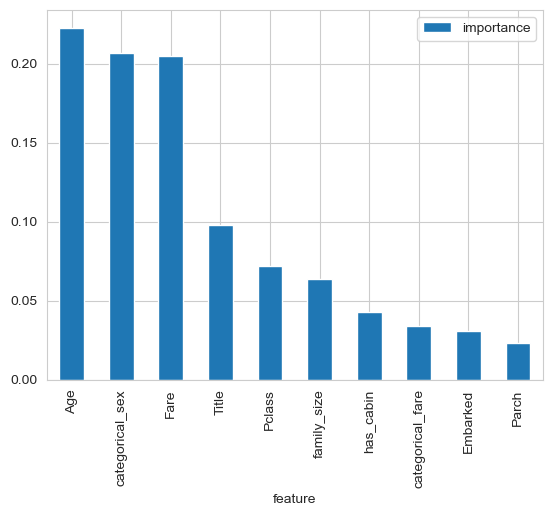

In [70]:
importances = pd.DataFrame(
    {
        "feature": x_train.columns,
        "importance": np.round(randomforest.feature_importances_, 3),
    }
)
importances = importances.sort_values("importance", ascending=False).set_index(
    "feature"
)
importances.plot.bar()


In [71]:
train_df  = train_df.drop("Parch", axis=1)
test_df  = test_df.drop("Parch", axis=1)


In [72]:
x_train = train_df.drop("Survived", axis=1)
y_train = train_df["Survived"]

random_forest = RandomForestClassifier(n_estimators=100, oob_score=True)
random_forest.fit(x_train.values, y_train.values)

y_prediction = random_forest.predict(test_df.values)

random_forest.score(x_train.values, y_train.values)

acc_random_forest = round(random_forest.score(x_train.values, y_train.values) * 100, 2)
print(
    round(
        acc_random_forest,
        2,
    ),
    "%",
)


98.54 %


In [73]:
print("oob score:", round(random_forest.oob_score_, 4)*100, "%")


oob score: 81.26 %


### Hyperparameter Tuning

This code takes runs in a long time
```
param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10, 25, 50, 70], "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], "n_estimators": [100, 400, 700, 1000, 1500]}

rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
clf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)
clf.fit(x_train.values, y_train.values)
clf.best_params_
```
The results were
```
{'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 12,
 'n_estimators': 1500}

```

Now lets run the model with this parameters

In [74]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(
    criterion="mse",
    min_samples_leaf=1,
    min_samples_split=12,
    n_estimators=1500,
    max_features="auto",
    oob_score=True,
    random_state=1,
    n_jobs=-1,
)

random_forest.fit(x_train.values, y_train)
y_prediction = random_forest.predict(test_df.values)

random_forest.score(x_train.values, y_train)


InvalidParameterError: The 'criterion' parameter of RandomForestRegressor must be a str among {'poisson', 'absolute_error', 'squared_error', 'friedman_mse'}. Got 'mse' instead.

Now we have a proper model,the problem is just, that it’s more complicated to evaluate a classification model than a regression model.